In [ ]:
# Default mount-path: /content/drive/Shared drives/Probstat

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [ ]:
# root_path = './gdrive/Shared drives/Probstat'
root_path = './'

## SF Covid-19 Dataset

In [ ]:
cases_df = pd.read_csv(root_path + '/data/COVID-19_Cases_Summarized_by_Date__Transmission_and_Case_Disposition.csv')

In [ ]:
cases_df.isna().sum()

Date                     0
Transmission Category    0
Case Disposition         0
Case Count               0
dtype: int64

We can verify in above query, 0 MISSING values were found 

### Pre-processing steps for SF Covid-19 Dataset

1.   Converting Date column into date-time dtype



In [ ]:
cases_df["Date"] = pd.to_datetime(cases_df["Date"], format="%Y/%m/%d")

2. Outlier Detection and Removal using Tukey's Rule:

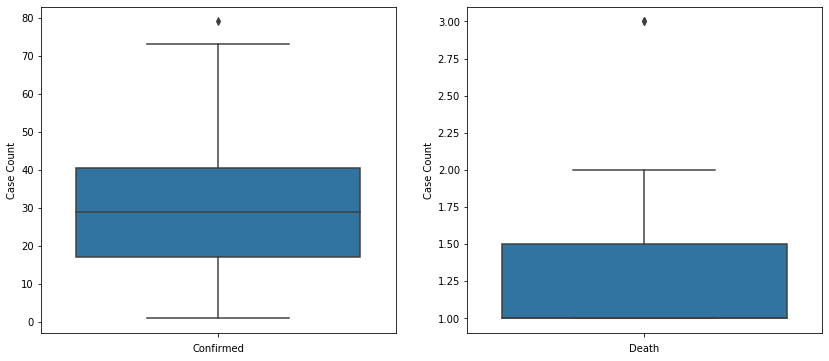

In [ ]:
# Detect outliers for each type of data
types = ['Confirmed', 'Death']
outliers = {}
f, axes = plt.subplots(1, 2, figsize=[14, 6])
for i, t in enumerate(types):
    curr_df = cases_df[cases_df['Case Disposition'] == t].groupby(['Date'])['Case Count'].sum().reset_index()
    curr_ds = curr_df['Case Count']
    sns.boxplot(curr_ds, orient='v', ax=axes[i]).set(xlabel=t)
    Q1 = np.percentile(curr_ds, 25)
    Q3 = np.percentile(curr_ds, 75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR
    outliers[t] = curr_df[(curr_ds < Q1 - outlier_step) | (curr_ds > Q3 + outlier_step)]

In [ ]:
# Drop outlier rows
for t in outliers.keys():
    for d in set(outliers[t]['Date']):
        cases_df.drop(cases_df[(cases_df['Case Disposition'] == t) & (cases_df['Date'] == d)].index, inplace=True)

## SF Crime Dataset

In [ ]:
crime_df = pd.read_csv(root_path + '/data/Police_Department_Incident_Reports__2018_to_Present.csv')

#### Checking missing/null values in Crime-Dataset

In [ ]:
crime_df.isna().sum()

Incident Datetime                                            0
Incident Date                                                0
Incident Time                                                0
Incident Year                                                0
Incident Day of Week                                         0
Report Datetime                                              0
Row ID                                                       0
Incident ID                                                  0
Incident Number                                              0
CAD Number                                               79225
Report Type Code                                             0
Report Type Description                                      0
Filed Online                                            269212
Incident Code                                                0
Incident Category                                          162
Incident Subcategory                                   

### Pre-processing steps for Crime Dataset:
1. Considering only non-null important Incident columns

In [ ]:
columns_to_consider = ["Incident Datetime", 
                       "Incident Date", 
                       "Incident Time", 
                       "Incident Year", 
                       "Incident Day of Week", 
                       "Report Datetime", 
                       "Row ID", 
                       "Incident ID", 
                       "Incident Number", 
                       "Report Type Code", 
                       "Report Type Description", 
                       "Incident Code", 
                       "Incident Category", 
                       "Incident Subcategory", 
                       "Incident Description", 
                       "Resolution", 
                       "Police District"]

In [ ]:
crime_df = crime_df[columns_to_consider]
crime_df = crime_df[crime_df["Incident Category"].notna()]

crime_df["Incident Date"] = pd.to_datetime(crime_df["Incident Date"], format="%Y/%m/%d")
crime_df["Incident Datetime"] = pd.to_datetime(crime_df["Incident Datetime"], format="%Y/%m/%d %I:%M:%S %p")

## Visualizations

In [ ]:
def convert_agg_df_into_flatten_df(df):
    df = df.reset_index()
    df.columns = [' '.join(col).strip() for col in df.columns.values]

    return df

### Un-Smoothened and Smoothened crime cases by day
For smoothening purposes used Simple Moving Average spanning over a week

In [ ]:
unique_crimes = crime_df.groupby(["Incident ID"]).agg({"Incident Date": "first"}).reset_index()
unique_crimes.head()

date_freq = unique_crimes["Incident Date"].value_counts().to_frame().reset_index()
date_freq = date_freq.rename(columns={"index": "date", "Incident Date": "count"})
date_freq = date_freq.sort_values(by="date")

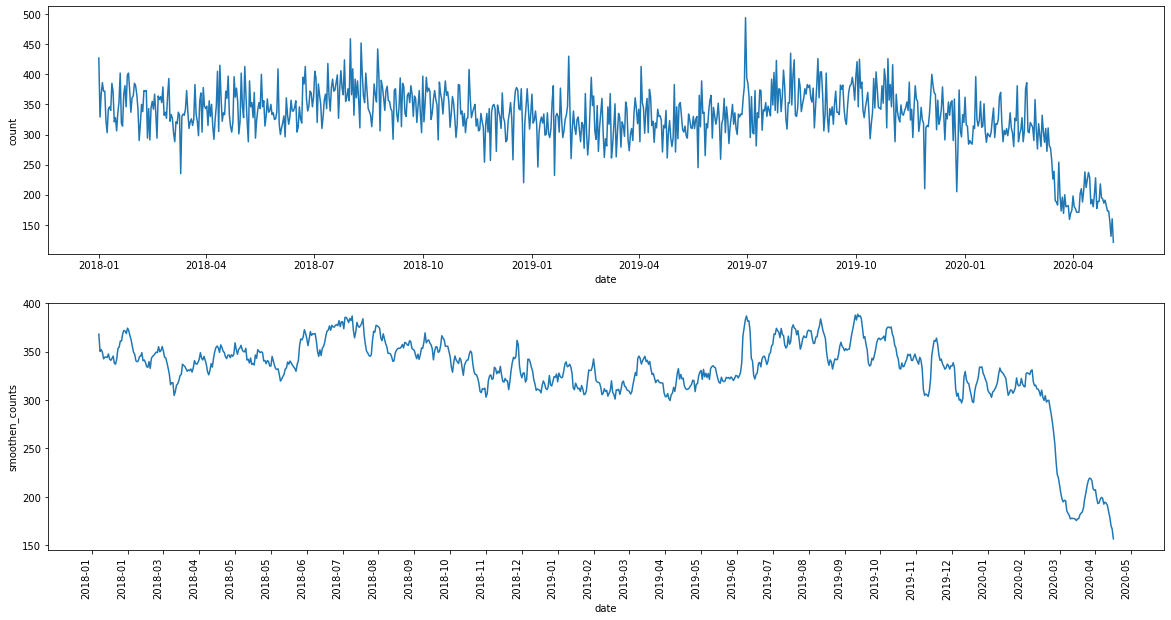

In [ ]:
figure, axes = plt.subplots(figsize=(20, 10), nrows=2, ncols=1)
sns.lineplot(x='date', y='count', data=date_freq, ax=axes[0])


date_freq['smoothen_counts'] = date_freq['count'].rolling(window=7).mean()

sns_axes = sns.lineplot(x='date', y='smoothen_counts', data=date_freq, ax=axes[1])

# Adding x-ticks for each month
base_date = datetime.datetime.strptime('2018-01-01', '%Y-%m-%d')
dates = [base_date + datetime.timedelta(days=i * 30) for i in range(30)]
xfmt = mdates.DateFormatter('%Y-%m')
axes[1].xaxis.set_major_formatter(xfmt)
axes[1].set_xticks(dates)

x_dates = [date.strftime("%Y-%m") for date in dates]
remnant = axes[1].set_xticklabels(labels=x_dates, rotation=90, ha='right')

### As we can see there's huge drop after first week of March 2020.
#### Because the first case of corona in San-Francisco was observed in 5th March, after which social-distancing measures were implemented

### Crimes filed Online vs Crimes filed related to Vehicle
See changes in trends of crime rates based on type of crime and filing status

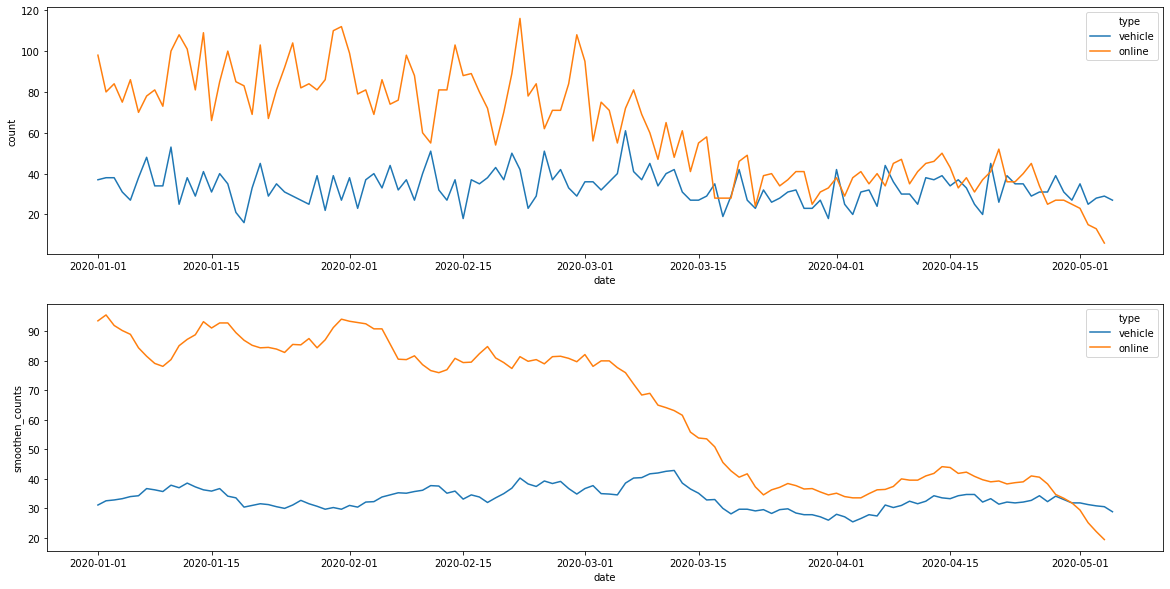

In [ ]:
vehicle_unique_reports = crime_df[(crime_df["Report Type Description"] == "Vehicle Initial") |
                                  (crime_df["Report Type Description"] == "Vehicle Supplement")]
vehicle_unique_reports = vehicle_unique_reports.groupby(["Incident ID"]).agg({"Incident Date": "first"}).reset_index()

online_unique_reports = crime_df[(crime_df["Report Type Description"] == "Coplogic Initial") |
                                             (crime_df["Report Type Description"] == "Coplogic Supplement")]
online_unique_reports = online_unique_reports.groupby(["Incident ID"]).agg({"Incident Date": "first"}).reset_index()

vehicle_stats = vehicle_unique_reports["Incident Date"].value_counts().to_frame().reset_index()
vehicle_stats = vehicle_stats.rename(columns={"index": "date", "Incident Date": "count"})
vehicle_stats = vehicle_stats.sort_values(by="date")
vehicle_stats['smoothen_counts'] = vehicle_stats['count'].rolling(window=7).mean()

online_stats = online_unique_reports["Incident Date"].value_counts().to_frame().reset_index()
online_stats = online_stats.rename(columns={"index": "date", "Incident Date": "count"})
online_stats = online_stats.sort_values(by="date")
online_stats['smoothen_counts'] = online_stats['count'].rolling(window=7).mean()

vehicle_stats["type"] = "vehicle"
online_stats["type"] = "online"

merged_df = pd.concat([vehicle_stats, online_stats])
merged_df = merged_df[merged_df["date"] > datetime.datetime(2019, 12, 31)]

figure, axes = plt.subplots(figsize=(20, 10), nrows=2, ncols=1)
sns.lineplot(x='date', y='count', hue="type", data=merged_df, ax=axes[0])

sns_axes = sns.lineplot(x='date', y='smoothen_counts', hue="type", data=merged_df, ax=axes[1])

## Conclusion
As we can observe that the crime reports that are filed online are reduce but the crime reports filed regarding stolen vehicle are more or less same. <br>
The reason behind this is that most of the online crime reports filed by citizens are related to Lost property or Theft of Property (https://www.fdle.state.fl.us/FCJEI/Programs/SLP/Documents/Full-Text/Vandewater-final-paper.aspx) <br>
Also, in subsequent visualizations we find that Larceny Theft is the most frequent crime that is dropped. <br>
In summary, the most frequent crime Larceny (Theft of Property) which is filed online is dropped after corona has begun. May be this is because most of the people don't leave their houses so that they could be criminally occupied

In [ ]:
merged_df = merged_df[merged_df["date"] > datetime.datetime(2019, 12, 31)]

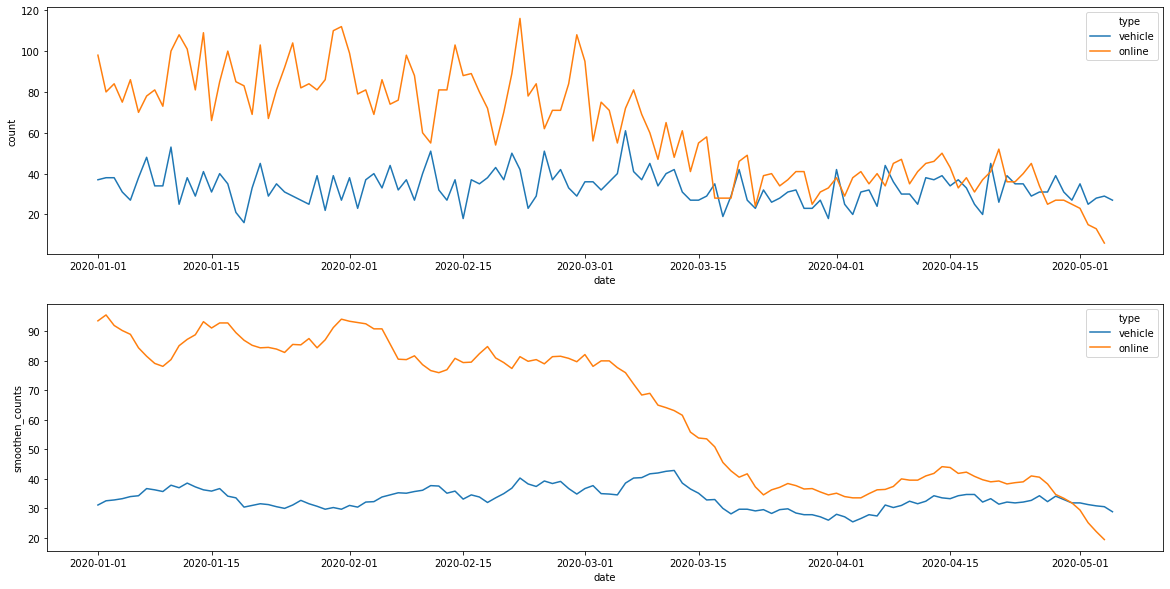

In [ ]:
figure, axes = plt.subplots(figsize=(20, 10), nrows=2, ncols=1)
sns.lineplot(x='date', y='count', hue="type", data=merged_df, ax=axes[0])

sns_axes = sns.lineplot(x='date', y='smoothen_counts', hue="type", data=merged_df, ax=axes[1])

#### Conclusion
We can observe that the crime reports that are filed online have reduced and the crime reports filed related to vehicles are more or less same. We expected online filing of crimes to increase during covid/lockdown period but that is not the case here. We also expected vehicle crimes to decrease since people would not be using their vehicles anymore but that does not seem to be the case either.

### Crime Rates Trend based on Crime Category
We look at some prominent types of crime incidents that are filed and observe their trends.

In [ ]:
concern_cases = ["Larceny Theft", "Malicious Mischief", "Burglary",
                 "Motor Vehicle Theft", "Traffic Violation Arrest",
                 "Civil Sidewalks", "Traffic Collision", "Vandalism"]
df_list = []
# list(crime_df["Incident Category"].value_counts()[:10].index)
for case in concern_cases:
    case_level_df = crime_df[crime_df["Incident Category"] == case]
    case_level_df = case_level_df.groupby(["Incident ID"]).agg({"Incident Date": "first"}).reset_index()
     
    case_level_df = case_level_df["Incident Date"].value_counts().to_frame().reset_index()
    case_level_df = case_level_df.rename(columns={"index": "date", "Incident Date": "count"})
    case_level_df = case_level_df.sort_values(by="date")
    
    case_level_df['smoothen_counts'] = case_level_df['count'].rolling(window=14).mean()
    case_level_df['type'] = case
    
    df_list.append(case_level_df)
    
merged_df = pd.concat(df_list)

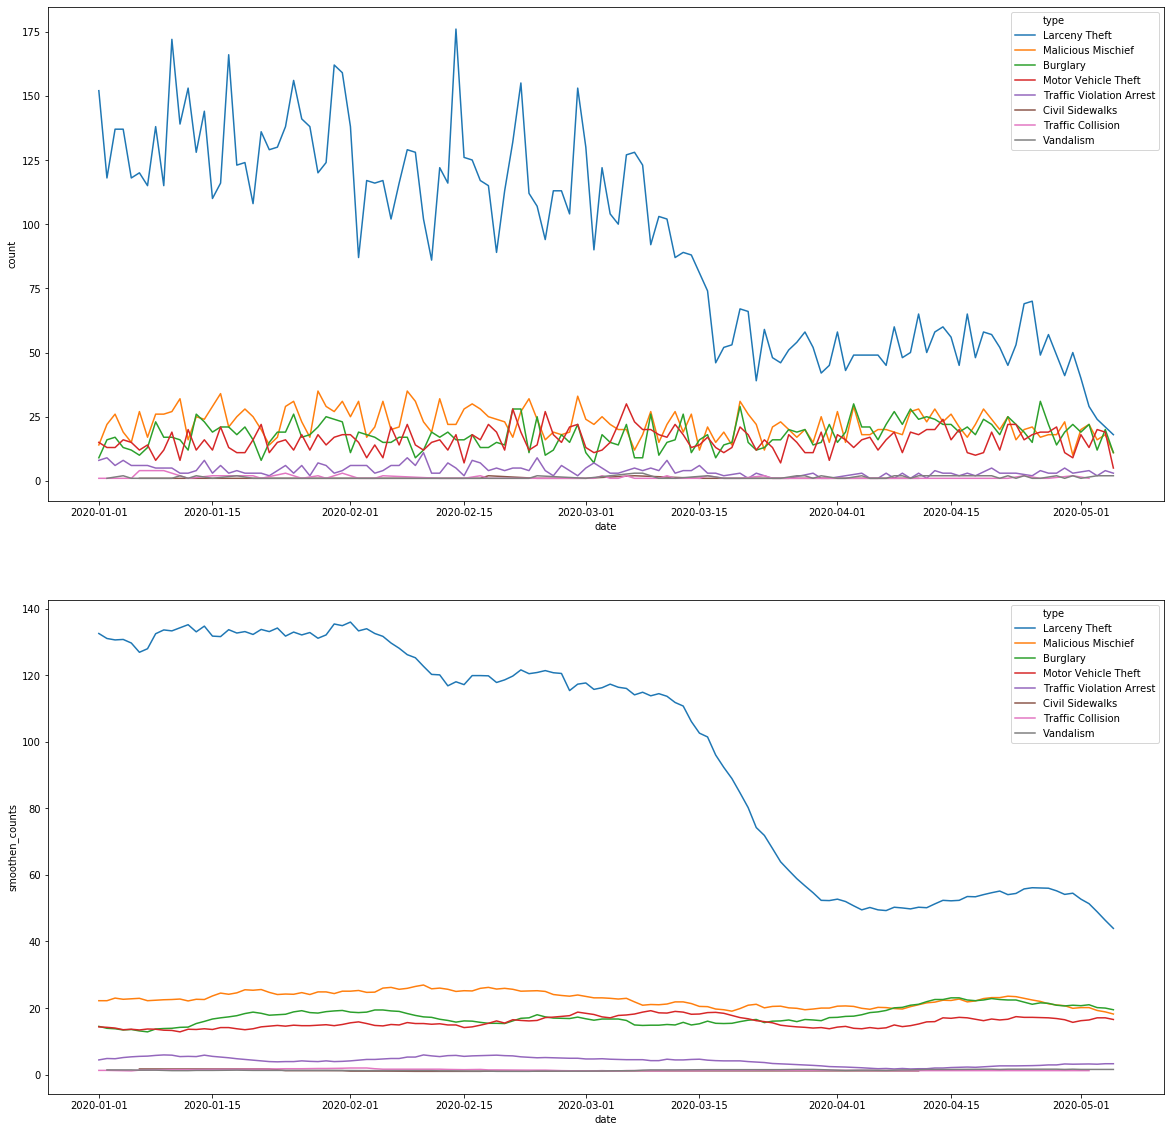

In [ ]:
merged_df = merged_df[merged_df["date"] > datetime.datetime(2019, 12, 31)]

figure, axes = plt.subplots(figsize=(20, 20), nrows=2, ncols=1)
sns.lineplot(x='date', y='count', hue='type', data=merged_df, ax=axes[0])


sns_axes = sns.lineplot(x='date', y='smoothen_counts', hue='type', data=merged_df, ax=axes[1])


## Conclusion:
1. Crime rates have been more or less same for all crimes except Larceny Theft and Traffic Violation Arrest
2. We believe the rates for Traffic Violation Arrest have reduced because very few people are driving on streets since the month of March
3. Larceny Theft is the unlawful taking, carrying, leading, or riding away of property from the possession or constructive possession of another. We believe since majority of people after March are staying at home and so are in physical possession of their belongings, there are fewer reports for arceny thefts.

# Required Inference 1
## Time series analysis for COVID19 data 
AR(3), AR(5), EWMA(0.5), EWMA(0.8) - For fatalities and number of cases

In [10]:
# Group the data by Case Disposition(Death, New Case) and Date
cases_df_grouped = cases_df.groupby(by=['Case Disposition', 'Date'])

# Search for the start date and end date in the data
start_date = cases_df['Date'].min()
end_date = cases_df['Date'].max()

# Calculate the total number of days based on start date and end date
num_of_days = end_date - start_date
num_of_days = num_of_days.days + 1

# Prepare a list of number of cases and deaths where index = index of the day from start date
num_cases_list = [ 0 for i in range(num_of_days)]
deaths_list = [0 for i in range(num_of_days)]

# Iterate through the groups of data to extract number of cases and fatalities 
# to store in a list
for name, group in cases_df_grouped:
  if name[0] == 'Confirmed':
    num_cases_list[(group['Date'].min() - start_date).days] = group['Case Count'].sum()
  else:
    deaths_list[(group['Date'].min()- start_date).days] = group['Case Count'].sum()


# Function to predict Auto Regression (AR) prediction values
def predict_ar(AR_p, day_of_the_week):

  training_data_count = num_of_days - 7 - AR_p + day_of_the_week + 1

  x_num_cases = [[0 for i in range(AR_p+1)] for i in range(training_data_count)]
  y_num_cases = [ 0 for i in range(training_data_count) ]

  x_deaths = [[0 for i in range(AR_p+1)] for i in range(training_data_count)]
  y_deaths = [ 0 for i in range(training_data_count) ]
  for i in range(training_data_count):
    x_num_cases[i][0] = 1
    y_num_cases[i] = num_cases_list[i+AR_p]

    x_deaths[i][0] = 1
    y_deaths[i] = deaths_list[i+AR_p]

    for j in range(AR_p):
      x_num_cases[i][AR_p - j] = num_cases_list[i+j]
      x_deaths[i][AR_p - j] = deaths_list[i+j]

  x_num_cases = np.array(x_num_cases)
  x_deaths = np.array(x_deaths)

  beta_num_cases = [0 for i in range(AR_p+1)]
  x_num_cases_transpose = np.matrix.transpose(x_num_cases)
  # Calculate the beta matrix for number of cases by the formula: beta = (inverse(X_transpose*X))*(X_transpose)*(Y)
  beta_num_cases = np.dot(np.dot(np.linalg.inv(np.dot(x_num_cases_transpose, x_num_cases)), x_num_cases_transpose), y_num_cases)

  beta_deaths = [0 for i in range(AR_p+1)]
  x_deaths_transpose = np.matrix.transpose(x_deaths)
  # Calculate the beta matrix for deaths by the formula: beta = (inverse(X_transpose*X))*(X_transpose)*(Y)
  beta_deaths = np.dot(np.dot(np.linalg.inv(np.dot(x_deaths_transpose, x_deaths)), x_deaths_transpose), y_deaths)

  # Calculate the predicted number of cases and deaths by the formula: Y = beta*X
  y_pred_num_cases = np.dot(x_num_cases, beta_num_cases)
  y_pred_deaths = np.dot(x_deaths, beta_deaths)

  return y_pred_num_cases[-1], y_pred_deaths[-1], y_num_cases[-1], y_deaths[-1]


# Function to predict the EWMA estimates 
def predict_ewma(alpha):

  y_pred_num_cases = [0 for i in range(len(num_cases_list))]
  y_pred_deaths = [0 for i in range(len(deaths_list))]

  # Calculate the initial predicted value as the actual value itself
  y_pred_num_cases[0] = num_cases_list[0]
  y_pred_deaths[0] = deaths_list[0]

  # For subsequent predictions, use the formula: alpha*(y_t) + (1-alpha)*(y_hat_t)
  for i in range(1,len(num_cases_list)):
    y_pred_num_cases[i] = round((alpha*num_cases_list[i-1] + (1-alpha)*y_pred_num_cases[i-1]), 2)
    y_pred_deaths[i] = round((alpha*deaths_list[i-1] + (1-alpha)*y_pred_deaths[i-1]), 2)

  return y_pred_num_cases[-7:], y_pred_deaths[-7:]

# Function to calculate MAPE and MSE values 
def calculate_mape_and_mse(y_pred_num_cases, y_num_cases, y_pred_deaths, y_deaths):
  mape_num_cases = 0
  mse_num_cases = 0

  mape_deaths = 0
  mse_deaths = 0
  for i in range(len(y_num_cases)):
    # Calculate MAPE for number of cases
    # Drop the cases when the actual value is zero
    if y_num_cases[i] != 0:
      mape_num_cases = mape_num_cases + (abs(y_num_cases[i] - y_pred_num_cases[i]))/y_num_cases[i]
    # Calculate MAPE for deaths
    # Drop the cases when the actual value is zero
    if y_deaths[i] != 0:
      mape_deaths = mape_deaths + (abs(y_deaths[i] - y_pred_deaths[i]))/y_deaths[i]
    # Calculate MSE for number of cases
    mse_num_cases = mse_num_cases + (y_num_cases[i] - y_pred_num_cases[i])*(y_num_cases[i] - y_pred_num_cases[i])
    # Calcuate MSE for deaths
    mse_deaths = mse_deaths + (y_deaths[i] - y_pred_deaths[i])*(y_deaths[i] - y_pred_deaths[i]) 
  mape_num_cases = (mape_num_cases*100)/len(y_num_cases)
  mape_deaths = (mape_deaths*100)/len(y_num_cases)
  mse_num_cases = mse_num_cases/len(y_num_cases)
  mse_deaths - mse_deaths/len(y_num_cases)

  mape_list = []
  mape_list.append(mape_num_cases)
  mape_list.append(mape_deaths)
  mse_list = []
  mse_list.append(mse_num_cases)
  mse_list.append(mse_deaths)

  return mape_list, mse_list


# Make empty lists to store the actual and predicted values for fatalities and number 
# of cases for last 1 week for AR(3), AR(5), EWMA(0.5), EWMA(0.8)
y_num_cases_7_days = []
y_deaths_7_days = []
y_pred_num_cases_7_days_ar_3 = []
y_pred_deaths_7_days_ar_3 = []
y_pred_num_cases_7_days_ar_5 = []
y_pred_deaths_7_days_ar_5 = []
y_pred_num_cases_ewma_5 = []
y_pred_deaths_ewma_5 = []
y_pred_num_cases_ewma_8 = []
y_pred_deaths_ewma_8 = []


# Call the functions to get the results 
for i in range(7):
  # Get the predictions for AR(3) for fatalities and number of cases for last 1 week
  results = predict_ar(3, i)
  y_pred_num_cases_7_days_ar_3.append(round(results[0],2))
  y_pred_deaths_7_days_ar_3.append(round(results[1],2))
  y_num_cases_7_days.append(results[2])
  y_deaths_7_days.append(results[3])

  # Get the predictions for AR(5) for fatalities and number of cases for last 1 week
  results_1 = predict_ar(5, i)
  y_pred_num_cases_7_days_ar_5.append(round(results_1[0],2))
  y_pred_deaths_7_days_ar_5.append(round(results_1[1],2))

# Get the predictions for EWMA(alpha=0.5) for fatalities and number of cases for last 1 week
y_pred_num_cases_ewma_5, y_pred_deaths_ewma_5 = predict_ewma(0.5)
# Get the predictions for EWMA(alpha=0.8) for fatalities and number of cases for last 1 week
y_pred_num_cases_ewma_8, y_pred_deaths_ewma_8 = predict_ewma(0.8)

# Calculate MAPE and MSE values for AR(3)
mape_ar_3, mse_ar_3 = calculate_mape_and_mse(y_pred_num_cases_7_days_ar_3, y_num_cases_7_days, y_pred_deaths_7_days_ar_3, y_deaths_7_days)
# Calculate MAPE and MSE values for AR(5)
mape_ar_5, mse_ar_5 = calculate_mape_and_mse(y_pred_num_cases_7_days_ar_5, y_num_cases_7_days, y_pred_deaths_7_days_ar_5,  y_deaths_7_days)
# Calculate MAPE and MSE values for EWMA with alpha 0.5
mape_ewma_5, mse_ewma_5 = calculate_mape_and_mse(y_pred_num_cases_ewma_5, y_num_cases_7_days, y_pred_deaths_ewma_5,  y_deaths_7_days)
# Calculate MAPE and MSE values for EWMA with alpha 0.8
mape_ewma_8, mse_ewma_8 = calculate_mape_and_mse(y_pred_num_cases_ewma_8, y_num_cases_7_days, y_pred_deaths_ewma_8, y_deaths_7_days)

print("Actual number of new cases for the last week(day1 - day7): "+str(y_num_cases_7_days))
print("Actual number of deaths for the last week: "+ str(y_deaths_7_days))
print()
print("Autoregression(3) number of cases prediction for the last week: "+str(y_pred_num_cases_7_days_ar_3))
print("Autoregression(3) deaths prediction for the last week: "+str(y_pred_deaths_7_days_ar_3))
print()
print("Autoregression(5) number of cases prediction for the last week: "+str(y_pred_num_cases_7_days_ar_5))
print("Autoregression(5) deaths prediction for the last week: "+str(y_pred_deaths_7_days_ar_5))
print()
print("EWMA with alpha 0.5 number of cases prediction for the last week: "+ str(y_pred_num_cases_ewma_5))
print("EWMA with alpha 0.5 deaths prediction for the last week: "+str(y_pred_deaths_ewma_5))
print()
print("EWMA with alpha 0.8 number of cases prediction for the last week: "+str(y_pred_num_cases_ewma_8))
print("EWMA with alpha 0.8 deaths prediction for the last week: "+str(y_pred_deaths_ewma_8))
print()
print("MAPE for AR(3) for number of cases: "+str(round(mape_ar_3[0],2)))
print("MAPE for AR(3) for deaths: "+str(round(mape_ar_3[1],2)))
print("MSE for AR(3) for number of cases: "+str(round(mse_ar_3[0],2)))
print("MSE for AR(3) for deaths: "+str(round(mse_ar_3[1],2)))
print()
print("MAPE for AR(5) for number of cases: "+str(round(mape_ar_5[0],2)))
print("MAPE for AR(5) for deaths: "+str(round(mape_ar_5[1],2)))
print("MSE for AR(5) for number of cases: "+str(round(mse_ar_5[0],2)))
print("MSE for AR(5) for deaths: "+str(round(mse_ar_5[1],2)))
print()
print("MAPE for EWMA with alpha 0.5 for number of cases: "+str(round(mape_ewma_5[0],2)))
print("MAPE for EWMA with alpha 0.5 for deaths: "+str(round(mape_ewma_5[1],2)))
print("MSE for EWMA with alpha 0.5 for number of cases: "+str(round(mse_ewma_5[0],2)))
print("MSE for EWMA with alpha 0.5 for deaths: "+str(round(mse_ewma_5[1],2)))
print()
print("MAPE for EWMA with alpha 0.8 for number of cases: "+str(round(mape_ewma_8[0],2)))
print("MAPE for EWMA with alpha 0.8 for deaths: "+str(round(mape_ewma_8[1],2)))
print("MSE for EWMA with alpha 0.8 for number of cases: "+str(round(mse_ewma_8[0],2)))
print("MSE for EWMA with alpha 0.8 for deaths: "+str(round(mse_ewma_8[1],2)))

Actual number of new cases for the last week(day1 - day7): [29, 50, 38, 73, 40, 6, 1]
Actual number of deaths for the last week: [1, 2, 1, 0, 0, 0, 0]

Autoregression(3) number of cases prediction for the last week: [31.31, 32.14, 44.89, 36.4, 57.34, 33.89, 15.7]
Autoregression(3) deaths prediction for the last week: [0.52, 0.68, 0.82, 0.52, 0.44, 0.5, 0.44]

Autoregression(5) number of cases prediction for the last week: [35.86, 29.7, 44.9, 41.11, 51.04, 34.02, 15.66]
Autoregression(5) deaths prediction for the last week: [0.44, 0.62, 0.86, 0.37, 0.36, 0.65, 0.74]

EWMA with alpha 0.5 number of cases prediction for the last week: [36.8, 32.9, 41.45, 39.72, 56.36, 48.18, 27.09]
EWMA with alpha 0.5 deaths prediction for the last week: [0.14, 0.57, 1.28, 1.14, 0.57, 0.28, 0.14]

EWMA with alpha 0.8 number of cases prediction for the last week: [36.62, 30.52, 46.1, 39.62, 66.32, 45.26, 13.85]
EWMA with alpha 0.8 deaths prediction for the last week: [0.03, 0.81, 1.76, 1.15, 0.23, 0.05, 0.0

## Assumption: 

There were a couple of days in Number of Cases data, where there was no entry. There were many entries in Deaths data for which there was no entry. We have assumed zero cases and deaths for such days and made predictions accordingly.

# Actual values:
## Number of cases ( Day 1, ...., Day 7 ): 
29, 50, 38, 73, 40, 6, 1

## Deaths: 
1, 2, 1, 0, 0, 0, 0

# Predicted values:

## AR(3)

### Number of cases: 
31.31, 32.14, 44.89, 36.4, 57.34, 33.89, 15.7

### Deaths: 
0.52, 0.68, 0.82, 0.52, 0.44, 0.5, 0.44

## AR(5)

### Number of cases:
35.86, 29.7, 44.9, 41.11, 51.04, 34.02, 15.66

### Deaths:
0.44, 0.62, 0.86, 0.37, 0.36, 0.65, 0.74


## EWMA ( alpha = 0.5 )

### Number of cases:
36.8, 32.9, 41.45, 39.72, 56.36, 48.18, 27.09

### Deaths:
0.14, 0.57, 1.28, 1.14, 0.57, 0.28, 0.14


## EWMA ( alpha = 0.8 ) 

### Number of cases: 
36.62, 30.52, 46.1, 39.62, 66.32, 45.26, 13.85

### Deaths:
0.03, 0.81, 1.76, 1.15, 0.23, 0.05, 0.01




# MAPE and MSE 
(Note: Records where actual value is 0 is disregarded in MAPE calculation)

## AR(3)
MAPE for number of cases: 298.59

MAPE for deaths: 18.86

MSE for number of cases: 429.42

MSE for deaths: 2.91

## AR(5) 

MAPE for number of cases: 298.1

MAPE for deaths: 19.86

MSE for number of cases: 377.95

MSE for deaths: 3.47

## EWMA ( alpha = 0.5 )

MAPE for number of cases: 495.52

MAPE for deaths: 26.5

MSE for number of cases: 600.03

MSE for deaths: 4.59

## EWMA ( alpha = 0.8 )

MAPE for number of cases: 305.34

MAPE for deaths: 33.21

MSE for number of cases: 573.8

MSE for deaths: 4.31


## Comments

For AR(3) and AR(5), we do not see a considerable difference in predictions for both number of cases and deaths. The MAPE and MSE for those techniques are also very similar. The EWMA (alpha=0.5) and EWMA(alpha=0.8) also predict similar values for most of the number of cases and deaths in the week, but are relatively less accurate. 


Generally, comparing the accuracy of all the techniques, AR seems much better than EWMA. Among all the performed techniques, the smallest MAPE percentage for both number of cases and deaths is observed for AR(3). The smallest MSE for number of cases is observed for AR(5), while the smallest MSE for deaths is observed for AR(3).  


The reason for such high MAPE and MSE for number of cases is the unusual actual numbers in San Francisco. The numbers are getting surprisingly low or are increasing with much slower rate than other places. Hence, the prediction will predict high values for number of cases and deaths, but the actual value is very low. For example, the number of cases for last 2 days is 6 and 1. 
For AR(3), the predictions are 33.89 and 15.7, which will give the percentage error as approx. 450 % and 1400 %. This will skew the MAPE values. 